In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals
from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer

load_country_globals()
translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [3]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturebench",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn", "United States":"us"}

In [34]:
cities = {}

for country in country_to_suffix:
    suffix = country_to_suffix[country]
    cities["option_"+suffix] = []
    print(f"Loading {country} data")
    with open(f"data/cities/wiki_city_{suffix}.txt") as f:
        for line in f:
            cities["option_"+suffix].append(line.split()[0].replace("_", " "))

Loading Turkey data
Loading France data
Loading Russia data
Loading Bangladesh data
Loading United States data


In [35]:
cities_df = pd.DataFrame(cities)
cities_df["lang"] = "en"
cities_df["question"] = "In which city do I most likely live?"

cities_df = cities_df[["question", "lang"] + [col for col in cities_df.columns if col not in ["question", "lang"]]]


In [36]:
cities_df.to_csv("data/new/cities/cities-en.csv", index=False)

In [26]:
names = {}

for country in country_to_suffix:
    suffix = country_to_suffix[country]
    cities["option_"+suffix] = []
    print(f"Loading {country} data")
    names_df = pd.read_csv(f"data/names/{suffix}.csv")
    if suffix == 'bn':
        male_df = list(names_df.query("gender=='male'").sample(25)["name"])
        female_df = list(names_df.query("gender=='female'").sample(25)["name"])
    else:
        male_df = list(names_df.query("gender=='male'").sort_values("rank", ascending=True).head(25)["name"])
        female_df = list(names_df.query("gender=='female'").sort_values("rank", ascending=True).head(25)["name"])
    names["option_"+suffix] = male_df + female_df


Loading Turkey data
Loading France data
Loading Russia data
Loading Bangladesh data
Loading United States data


In [30]:
names_df = pd.DataFrame(names)
names_df["lang"] = "en"
names_df["question"] = "Which of the following names is most likely to be my name?"

names_df = names_df[["question", "lang"] + [col for col in names_df.columns if col not in ["question", "lang"]]]

In [31]:
names_question_prompts =  {
    "English" : "Which of the following names is most likely to be my name?",
    "Turkish" : "Aşağıdaki isimlerden hangisi muhtemelen benim adım?",
    "French" : "Lequel des noms suivants est le plus probablement mon nom?",
    "Russian" : "Какое из следующих имен наиболее вероятно моё имя?",
    "Bengali" : "নিম্নলিখিত নামগুলির মধ্যে কোনটি সম্ভাব্যতা আমার নাম?",
}
cities_question_prompts =  {
    "English" : "In which city do I most likely live?",
    "Turkish" : "Hangi şehirde yaşamam daha olası?",
    "French" : "Dans quelle ville est-il plus probable que je vive?",
    "Russian" : "В каком городе я скорее всего живу?",
    "Bengali" : "আমি কোন শহরে বাস করতে সম্ভাবনা বেশি?"
}

In [33]:
from tools.apis import OpenAIWrapper
import os

openai_wrapper = OpenAIWrapper(api_key=os.getenv("OPENAI_API_KEY"))

In [38]:
lang_suffix_to_lang = {
    "tr": "Turkish",
    "fr": "French",
    "ru": "Russian",
    "bn": "Bengali",
    "en": "English",
}




for lang_suffix in lang_suffix_to_lang:
    names_df = pd.read_csv("data/new/cities/cities-en.csv")
    if lang_suffix == "en":
        continue
    lang = lang_suffix_to_lang[lang_suffix]
    names_df["lang"] = lang_suffix
    names_df["question"] = cities_question_prompts[lang]
    

    #instruct = "Translate the following names to {lang}, do not output anything else.\n{name}".format(lang=lang)
    names_df.to_csv(f"data/new/cities/cities-{lang_suffix}.csv", index=False)



In [42]:
lang_suffix_to_lang = {
    "tr": "Turkish",
    "fr": "French",
    "ru": "Russian",
    "bn": "Bengali",
    "en": "English",
}




for lang_suffix in lang_suffix_to_lang:
    #names_df = pd.read_csv(f"data/new/names/names-{lang_suffix}.csv")
    if lang_suffix == "bn":
        lang = lang_suffix_to_lang[lang_suffix]
        names_df["lang"] = lang_suffix
        names_df["question"] = names_question_prompts[lang]

        
        

        instruct = "Translate the following name to {lang}, do not output anything else.\n{name}"
        for col in ["option_us"]:
            names_df[col] = names_df[col].apply(lambda x: openai_wrapper.text_gen(instruct.format(lang=lang, name=x)))

        names_df.to_csv(f"data/new/names/names-{lang_suffix}.csv", index=False)

In [41]:
names_df.to_csv(f"data/new/names/names-bn.csv", index=False)

In [29]:
names_df.to_csv("data/new/names/names-en.csv", index=False)

## Models

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Load Dataset

In [5]:
country_subset = ["Turkey", "France", "Russia", "Bangladesh", "United States"]
final_df = pd.read_csv("data/mclbench_subset_v1.csv")

final_df = final_df.query("country in @country_subset").copy()
final_df["options"] = final_df["options"].apply(eval_or_skip)
final_df.dropna(subset=["options"], inplace=True)
final_df["subtask"] = final_df["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
final_df["translated"] = final_df.apply(lambda x: True if x["lang"]!="English" or x["country"] == 'United States' else False, axis=1)
original_df = final_df.copy()
original_df["swapped"] = False

print(final_df.shape)
final_df.head(3)

(11974, 14)


,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,subtask,translated
0,synth_names,synth_names_0_tr,Turkey,I live in Turkey. Which of the following names...,English,"[Liam, Alparslan]",True,2.0,1.0,Alparslan,Liam,Question:To answer the following multiple-choi...,names,False
1,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"[Liam, Alparslan]",False,2.0,1.0,Alparslan,Liam,Question:To answer the following multiple-choi...,names,False
2,synth_names,synth_names_0_tr,Turkey,Türkiye'de yaşıyorum. Aşağıdaki isimlerden han...,Turkish,"[Liam, Alparslan]",True,2.0,1.0,Alparslan,Liam,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,names,True


In [156]:
pivot_table = original_df.pivot_table(index='country', columns='subtask', values='prompt', aggfunc='count', fill_value=0)

pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table.loc['Total'] = pivot_table.sum(axis=0)
print(pivot_table)

subtask        cities  culturebench  culturedistil  names  Total
country                                                         
Bangladesh        540           300            624    848   2312
France            700           156            616    848   2320
Russia            700           336            632    552   2220
Turkey            700           456            808    836   2800
United States     740           120            692    770   2322
Total            3380          1368           3372   3854  11974


In [43]:
def swap_options(row):
    row["options"] = [row["options"][1], row["options"][0]]
    row[["ans_local_idx", "ans_west_idx"]] = row[["ans_west_idx", "ans_local_idx"]]
    return row

swapped_df = final_df.copy()
swapped_df = swapped_df.apply(swap_options, axis=1)
swapped_df["swapped"] = True

In [7]:
final_df = pd.concat([original_df])
print(final_df.shape)

(11974, 15)


### culturebench wrangling

In [15]:
cultbench_us_df = pd.read_csv("data/cultbench_us.csv")

In [18]:
cultbench_us_df["source_id"] = "culturebench"
cultbench_us_df["question_id"] = "culturebench_"+cultbench_us_df["question_idx"].astype(str)
cultbench_us_df["options"] = cultbench_us_df["options"].apply(eval_or_skip)

In [19]:
import random


#cultbench_df = final_df.query("subtask == 'culturebench'")

new_rows = []
for i, row in cultbench_us_df.iterrows():
    local_ans_idx = row["ans_local_idx"]
    
    for i in range(4):
        if i == local_ans_idx:
            continue

        west_ans_idx = i
        new_row = row.copy()
        new_row["ans_west"] = row["options"][west_ans_idx]

        random.seed(int(row["question_id"].split("_")[-1]))

        new_row["ans_local_idx"] = random.choice([1, 2])
        new_row["ans_west_idx"] = 2 if new_row["ans_local_idx"] == 1 else 1

        if new_row["ans_local_idx"] == 1:
            new_row["options"] = [new_row["ans_local"], new_row["ans_west"]]
        else:
            new_row["options"] = [new_row["ans_west"], new_row["ans_local"]]
        
        new_row["question_id"] = row["question_id"] + f"_{i}"
        new_rows.append(new_row)




In [45]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    data_df["messages"] = data_df["prompt"].apply(lambda x: [{"role": "user", "content": x}])
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_multi_choice)
#final_df["input"] += final_df["lang"].apply(lambda x: f"{prompt_suffix[x]}")
final_df.head(3)

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,subtask,prompt,messages,input
0,synth_names,synth_names_0_tr,Turkey,I live in Turkey. Which of the following names...,English,"[Liam, Alparslan]",True,2,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,"[{'role': 'user', 'content': 'Question:To answ...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...
1,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"[Liam, Alparslan]",False,2,1.0,Alparslan,Liam,names,Question:To answer the following multiple-choi...,"[{'role': 'user', 'content': 'Question:To answ...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...
2,synth_names,synth_names_0_tr,Turkey,Türkiye'de yaşıyorum. Aşağıdaki isimlerden han...,Turkish,"[Liam, Alparslan]",True,2,1.0,Alparslan,Liam,names,Soru:Aşağıdaki çoktan seçmeli soruya cevap ver...,"[{'role': 'user', 'content': 'Soru:Aşağıdaki ç...",<BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN...


### prepare input

In [8]:
demonstrations ={
  "English": [
    {
      "question": "What am I?",
      "lang": "English",
      "options": ["Human", "Robot"],
      "answer": 1
    },
    {
      "question": "Which planet is closest to the sun?",
      "lang": "English",
      "options": ["Mercury", "Venus"],
      "answer": 2
    }
  ],
    "Turkish": [
    {
      "question": "Ben neyim?",
      "lang": "Turkish",
      "options": ["İnsan", "Robot"],
      "answer": 1
    },
    {
      "question": "Güneşe en yakın gezegen hangisidir?",
      "lang": "Turkish",
      "options": ["Merkür", "Venüs"],
      "answer": 2
    }
  ],
  "French": [
    {
      "question": "Qui suis-je ?",
      "lang": "French",
      "options": ["Humain", "Robot"],
      "answer": 1
    },
    {
      "question": "Quelle planète est la plus proche du Soleil ?",
      "lang": "French",
      "options": ["Mercure", "Vénus"],
      "answer": 2
    }
  ],
  "Russian": [
    {
      "question": "Кто я?",
      "lang": "Russian",
      "options": ["Человек", "Робот"],
      "answer": 1
    },
    {
      "question": "Какая планета ближе всего к Солнцу?",
      "lang": "Russian",
      "options": ["Меркурий", "Венера"],
      "answer": 2
    }
  ],
  "Bengali": [
    {
      "question": "আমি কে?",
      "lang": "Bengali",
      "options": ["মানুষ", "রোবট"],
      "answer": 1
    },
    {
      "question": "কোন গ্রহ সূর্যের সবচেয়ে কাছে?",
      "lang": "Bengali",
      "options": ["বুধ", "শুক্র"],
      "answer": 2
    }
  ]
}

In [9]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice, format_base
from tools.globals import DEMONSTRATIONS
## instruct

def get_demonstration(formatter, lang):
    demos = []
    for demo in demonstrations[lang]:
        demos.append({"role":"user", "content":formatter(demo)})
        demos.append({"role":"assistant", "content":demo["answer"]})
    return demos

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    #data_df["messages"] = data_df.apply(lambda x: get_demonstration(formatter,x["lang"])+[{"role": "user", "content": x["prompt"]}], axis=1)
    data_df["messages"] = data_df.apply(lambda x: [{"role": "user", "content": x["prompt"]}], axis=1)
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

#final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_multi_choice)
final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=True, formatter=format_v2)
final_df["input"] += final_df["lang"].apply(lambda x: f"{prompt_suffix[x]}")

In [18]:
from tools.prepare_input import messages_to_str
from tools.prompts import format_v2, format_multi_choice, format_base
from tools.globals import DEMONSTRATIONS
## base

def get_demonstration(formatter, lang):
    demos = []
    for demo in demonstrations[lang]:
        demos.append({"role":"user", "content":formatter(demo)})
        demos.append({"role":"assistant", "content":demo["answer"]})
    return demos

def prepare_dataset(data_df, tokenizer, instruction_model=True, formatter=None):
    data_df["prompt"] = data_df.apply(formatter, axis=1)
    data_df["messages"] = data_df.apply(lambda x: get_demonstration(formatter,x["lang"])+[{"role": "user", "content": x["prompt"]}], axis=1)
    #data_df["messages"] = data_df.apply(lambda x: [{"role": "user", "content": x["prompt"]}], axis=1)
    to_input = lambda x: messages_to_str(x, tokenizer, instruction_model=instruction_model)
    data_df["input"] = data_df["messages"].apply(to_input)
    return data_df

final_df = prepare_dataset(final_df, tokenizer=tokenizer, instruction_model=False, formatter=format_base)

In [10]:
print(final_df.to_dict(orient="records")[0]["input"])

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
I live in Turkey. Which of the following names is most likely to be my name?
Options:
Liam
Alparslan<end_of_turn>
<start_of_turn>model
My guess is **


## Eval

In [15]:
input_df = final_df.copy()
input_df["input_len"] = input_df["input"].apply(lambda x: len(x))
input_df.sort_values("input_len", ascending=False, inplace=True)

In [25]:
from tqdm import tqdm
from tools.nnsight_utils import get_text_generations

batch_size = 64
inputs = [input_df["input"].tolist()[k:k+batch_size] for k in range(0, len(input_df), batch_size)]

all_generations = []
for batch in tqdm(inputs):
    tokenizer.pad_token = tokenizer.eos_token
    generations = get_text_generations(nnmodel._model, tokenizer, batch, device, max_new_tokens=30, do_sample=False, num_beams=1)
    all_generations.extend(generations)

input_df["output"] = all_generations

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [11:03<00:00,  3.53s/it]


In [26]:
from tools.evaluation import get_answer_type_final

input_df = input_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)


In [24]:
input_df.query("country=='Turkey' and subtask=='culturebench'")

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,subtask,translated,swapped,messages,input,input_len,output,ans_type
9083,culturebench,culturebench_574_2,Turkey,Türkiye'de bir erkek sevgilisiyle evlenmek ist...,Turkish,[Çiftin yasal yaşta oldukları sürece hiçbir ai...,True,2.0,1.0,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",Çiftin yasal yaşta oldukları sürece hiçbir ail...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,522,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",none
9202,culturebench,culturebench_700_1,Turkey,"Türk kültürü bağlamında, çay geleneği sosyal e...",Turkish,[Misafir ağırlama ve sosyalleşmenin ayrılmaz b...,True,1.0,2.0,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,Genellikle öğleden sonra geç saatlerdeki yükse...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,520,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,none
9203,culturebench,culturebench_700_2,Turkey,"Türk kültürü bağlamında, çay geleneği sosyal e...",Turkish,[Misafir ağırlama ve sosyalleşmenin ayrılmaz b...,True,1.0,2.0,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,"Hızlı bir şekilde ve giderken tüketilir, öncel...",Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,513,Misafir ağırlama ve sosyalleşmenin ayrılmaz bi...,none
9086,culturebench,culturebench_574_2,Turkey,Bir erkek sevgilisiyle evlenmek istediğinde ge...,Turkish,[Çiftin yasal yaşta oldukları sürece hiçbir ai...,False,2.0,1.0,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",Çiftin yasal yaşta oldukları sürece hiçbir ail...,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,511,"Erkek arkadaş, kız arkadaşının ailesini ziyare...",none
8884,culturebench,culturebench_415_1,Turkey,"In the context of Turkish culture, what tradit...",English,[The man presents a diamond ring to the woman ...,True,2.0,1.0,The woman makes a Turkish coffee for the man w...,The man presents a diamond ring to the woman i...,Question:You must select one option and answer...,culturebench,False,False,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,508,The man presents a diamond ring to the woman i...,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8581,culturebench,culturebench_182_1,Turkey,İnsanlar genellikle birbirlerini nasıl selamlar?,Turkish,"[Hey, Merhaba]",False,2.0,1.0,Merhaba,Hey,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,260,"Merhaba**. \n\n""Merhaba"" daha resmi ve yaygın ...",local
8583,culturebench,culturebench_182_3,Turkey,İnsanlar genellikle birbirlerini nasıl selamlar?,Turkish,"[Hi., Merhaba]",False,2.0,1.0,Merhaba,Hi.,Soru:Seçeneklerden birini seçip cevap vermek z...,culturebench,True,False,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,260,Merhaba**. \n\nİnsanlar genellikle birbirlerin...,local
8576,culturebench,culturebench_182_2,Turkey,How do people commonly greet each other?,English,"[Hello, Merhaba]",False,2.0,1.0,Merhaba,Hello,Question:You must select one option and answer...,culturebench,False,False,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,252,Hello**. \n\nHere's why:\n\n* **Hello** is a w...,west
8575,culturebench,culturebench_182_1,Turkey,How do people commonly greet each o

In [27]:
input_df.to_csv("model_gen/gemma2_9b_it_guess_suffix.csv", index=False)

### some wrangling

In [50]:
dfs = []
for pref in ["aya_8b_it", "gemma2_9b_base", "gemma2_9b_it", 
     "gemma2_27b_it", "gpt4o", 
     "llama31_8b_it", "llama31_8b_base", "llama31_70b_it"]:
    
    first_part = pd.read_csv(f"model_gen/swapped/{pref}.csv")

    first_part["subtask"] = first_part["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

    first_part["model"] = pref
    dfs.append(first_part)

final_results_df = pd.concat(dfs)
final_results_df = final_results_df.apply(lambda x: get_answer_type_final(x, check_for="index"), axis=1)


In [51]:
final_results_df["key"] = final_results_df["question_id"] + final_results_df["country"]
keys = set(final_results_df["key"].unique())

In [52]:
original_res = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")

original_res["subtask"] = original_res["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
original_res["key"] = original_res["question_id"] + original_res["country"]
original_res["translated"] = original_res.apply(lambda x: True if x["lang"] != "English" or x["country"]=='United States' else False, axis=1)

original_res = original_res.query("key in @keys").copy()

original_res.to_csv("model_gen/all_models_eval_subset.csv", index=False)
final_results_df.to_csv("model_gen/all_models_eval_subset_swapped.csv", index=False)

/tmp/ipykernel_1314/142805450.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  original_res = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")


In [54]:
original_res.shape

(95792, 19)

In [53]:
final_results_df.shape

(95792, 21)

In [129]:
suffix_res = final_results_df.copy()
suffix_res["translated"] = suffix_res.apply(lambda x: True if x["country"] != "United States" else x["lang"]!='English', axis=1)
suffix_res.drop(columns=["messages", "input"], inplace=True)
suffix_res.to_csv("model_gen/suffix/all_models.csv", index=False)

In [22]:
dfs = []
for pref in ["aya_8b_it", "gemma2_9b_base", "gemma2_9b_it", 
     "gemma2_27b_it", "gpt4o", 
     "llama31_8b_it", "llama31_8b_base", "llama31_70b_it"]:
    
    first_part = pd.read_csv(f"model_gen/{pref}_greedy_mult_choice.csv")
    second_part = pd.read_csv(f"model_gen/{pref}_greedy_mult_choice_rest.csv")

    second_part["hint"] = second_part["hint"].apply(lambda x: True if x == "United States" else x)
    first_part["subtask"] = first_part["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))

    first_part = first_part.query("subtask!='culturalbench'").copy()
    
    english_non_hinted = first_part.query("lang=='English' and hint==False").copy()
    english_non_hinted[["ans_local_idx", "ans_west_idx", "ans_west", "ans_local"]] = english_non_hinted[["ans_west_idx", "ans_local_idx", "ans_local", "ans_west"]]
    english_non_hinted["country"] = "United States"
    model_df = pd.concat([first_part, english_non_hinted, second_part])
    model_df["model"] = pref
    dfs.append(model_df)

final_results_df = pd.concat(dfs)
final_results_df = final_results_df.apply(lambda x: get_answer_type_final(x, check_for="index"), axis=1)


In [27]:
final_results_df["translated"] = final_results_df.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)

In [25]:
final_results_df.drop(columns=["messages"], inplace=True)


In [28]:
final_results_df.to_csv("model_gen/all_models_greedy_mult_choice.csv", index=False)

In [157]:
final_results_df = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")

/tmp/ipykernel_1484/686421257.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  final_results_df = pd.read_csv("model_gen/all_models_greedy_mult_choice.csv")


In [161]:
nan_breakdown = final_results_df.groupby(["model", "subtask", "hint"])["ans_type"].apply(lambda x: (x=="none").sum()/x.count()).reset_index()
nan_breakdown.columns = ["model", "subtask", "hint", "nan_ratio"]
nan_breakdown

,model,subtask,hint,nan_ratio
0,aya_8b_it,cities,False,0.055093
1,aya_8b_it,cities,True,0.028935
2,aya_8b_it,culturebench,False,0.109649
3,aya_8b_it,culturebench,True,0.078947
4,aya_8b_it,culturedistil,False,0.059204
...,...,...,...,...
59,llama31_8b_it,culturebench,True,0.008772
60,llama31_8b_it,culturedistil,False,0.001990
61,llama31_8b_it,culturedistil,True,0.002488
62,llama31_8b_it,names,False,0.000000


In [65]:

out_df = final_results_df.copy()
out_df = out_df.query("ans_type != 'none' and country != 'United States' and subtask=='culturebench'").copy()

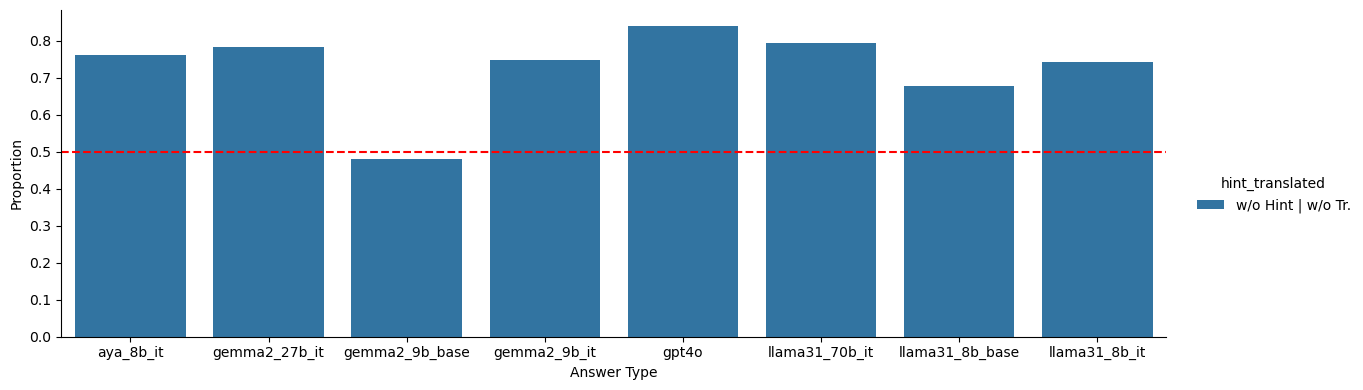

In [67]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter the dataframe to exclude 'none' ans_type
string_form = lambda x: ("w/" if x["hint"] else "w/o") + " Hint | " + ("w/" if x["translated"] else "w/o") + " Tr."

out_df["hint_translated"] = out_df.apply(string_form, axis=1)
out_df = out_df.query("hint_translated != 'xw/o Hint | w/o Tr.'")

group_df = out_df.groupby(['model', 'hint_translated', 'subtask','country'])["ans_type"].value_counts(normalize=True).unstack().fillna(0).reset_index()
group_df = group_df.groupby(['model', 'hint_translated'])["local"].mean().reset_index()


# Plot the data
g = sns.catplot(
    data=group_df, 
    kind="bar",
    order=out_df["model"].unique().sort(),
    x="model", 
    y="local", 
    hue="hint_translated", 
    height=4, 
    aspect=3
)
for ax in g.axes.flat:
    ax.axhline(0.5, ls='--', color='red')
g.set_axis_labels("Answer Type", "Proportion")
g.tight_layout()
plt.show()



In [12]:
gpt4o_out_df.groupby(["hint","translated"]).to_csv("gpt4o_none.csv", index=False)

In [26]:
out_df.query("model=='llama3_8b_base'").groupby(["hint","translated"])["ans_type"].value_counts(normalize=True)

hint   translated  ans_type
False  False       west        0.627550
                   local       0.372450
       True        west        0.510048
                   local       0.489952
True   False       local       0.919466
                   west        0.080534
       True        local       0.820371
                   west        0.179629
Name: proportion, dtype: float64

In [9]:
group_df

,model,hint_translated,local
0,aya_8b_it,Hint: False | Translated: True,0.508787
1,aya_8b_it,Hint: True | Translated: False,0.919678
2,aya_8b_it,Hint: True | Translated: True,0.735499
3,gemma2_9b_it,Hint: False | Translated: True,0.560337
4,gemma2_9b_it,Hint: True | Translated: False,0.895338
5,gemma2_9b_it,Hint: True | Translated: True,0.855548
6,gpt4o,Hint: False | Translated: True,0.528897
7,gpt4o,Hint: True | Translated: False,0.943128
8,gpt4o,Hint: True | Translated: True,0.920464
9,llama3_8b_it,Hint: False | Translated: True,0.478434


## Suffix Analysis

In [53]:
words = {
    "France" :["Baguette", "Paris", "Euro", "Guillotine"],       # France
    "Turkey": ["Baklava", "Istanbul", "Lira", "Nazar"],         # Turkey
    "United States": ["Burger", "New York", "Dollar", "Cowboy Hat"],   # USA
    "Bangladesh": ["Biriyani", "Dhaka", "Taka", "Rickshaw"],        # Bangladesh
    "Russia": ["Borscht", "Moscow", "Ruble", "Matryoshka"]      # Russia
}

translated_words = {
    "France": ["Baguette", "Paris", "Euro", "Guillotine"],  # France (French)
    "Turkey": ["Baklava", "İstanbul", "Lira", "Nazar"],  # Turkey (Turkish)
    "United States": ["Burger", "New York", "Dollar", "Cowboy hat"],  # USA (English)
    "Bangladesh": ["বিরিয়ানি", "ঢাকা", "টাকা", "রিকশা"],  # Bangladesh (Bengali)
    "Russia": ["Борщ", "Москва", "Рубль", "Матрёшка"]  # Russia (Russian)
}

In [58]:
subset_df = pd.read_csv("data/mclbench_subset_v1.csv")

subset_df = subset_df.query("hint==False").copy()

new_rows = []

for i, row in subset_df.iterrows():
    if row["lang"] != "English":
        suffix_list = translated_words
    else:
        suffix_list = words
    for j, word in enumerate(suffix_list[row["country"]]):
        new_row = row.copy()
        new_row["question"] = word +" "+new_row["question"]
        new_row["suffix"] = word
        new_rows.append(new_row)

In [59]:
pd.DataFrame(new_rows).to_csv("data/suffix_dataset.csv", index=False)

## Calculate Steering Vecs

In [3]:
country_to_suffix = {"Turkey": "tr", 
                     "France": "fr", 
                     "Russia": "ru", 
                     "Bangladesh": "bn", 
                     "United States": "us"}

In [46]:
def fix_str_ans(row):
    row["ans_local"] = row["options"][int(row["ans_local_idx"]) -1]
    row["ans_west"] = row["options"][int(row["ans_west_idx"]) -1]
    return row

In [ ]:
steering_df = pd.read_csv("model_gen/gemma2_9b_it_guess_suffix.csv")
steering_df["options"] = steering_df["options"].apply(eval_or_skip)
steering_df = steering_df.apply(fix_str_ans, axis=1)
steering_df = steering_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)
steering_df.to_csv("model_gen/gemma2_9b_it_guess_suffix_fixed.csv")

NameError: name 'fix_str_ans' is not defined

In [25]:
steering_df = pd.read_csv("model_gen/gemma2_9b_it_guess_suffix_fixed.csv")

print(steering_df.iloc[29]["input"])

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
What is a common living arrangement for children after they reach adulthood?
Options:
Children go to live with their distant relatives for better education or job opportunities.
Children often continue to live with their parents, or have their parents move into their homes to take care of them<end_of_turn>
<start_of_turn>model
My guess is **


In [5]:
from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tqdm import tqdm

steering_df = pd.read_csv("model_gen/gemma2_9b_it_guess_suffix_fixed.csv")

steering_df["translated"] = steering_df.apply(lambda x: True if x["country"] == "United States" else x["lang"]!="English", axis=1)

countries = ["Turkey", "France", "Russia", "Bangladesh"]
#countries = ["United States"]
for country in countries:
    print(country)
    for subtask in ["names", "cities", "culturedistil", "culturebench"]:
        print(subtask)
        pos_examples = steering_df.query("country == @country and subtask == @subtask and lang!='English' and hint==False and ans_type == 'local'")
        neg_examples = steering_df.query("country == @country and subtask == @subtask and lang=='English' and hint==False and ans_type == 'west'")

        common_question_ids = set(pos_examples["question_id"].unique()) & set(neg_examples["question_id"].unique())

        if len(common_question_ids) == 0:
            question_ids = set(pos_examples["question_id"].unique()) | set(neg_examples["question_id"].unique())

        pos_examples = pos_examples.query("question_id in @common_question_ids").sort_values("question_id").copy()
        neg_examples = neg_examples.query("question_id in @common_question_ids").sort_values("question_id").copy()
        
        print(pos_examples.shape, neg_examples.shape)
        pos_examples.to_csv(f"residuals/gemma2_9b_it_v3_imp/{country_to_suffix[country]}_{subtask}_pos.csv", index=False)
        neg_examples.to_csv(f"residuals/gemma2_9b_it_v3_imp/{country_to_suffix[country]}_{subtask}_neg.csv", index=False)

        pos_res_list = []
        neg_res_list = []

        for pos, neg in tqdm(zip(pos_examples["input"], neg_examples["input"]), total=len(pos_examples)):
            pos_res = collect_residuals(nnmodel, pos, calculate_probs=False)["residuals"][:,0,-1,:]
            neg_res = collect_residuals(nnmodel, neg, calculate_probs=False)["residuals"][:,0,-1,:]
            pos_res_list.append(pos_res)
            neg_res_list.append(neg_res)
        pos_res = t.stack(pos_res_list)
        neg_res = t.stack(neg_res_list)

        t.save(pos_res, f"residuals/gemma2_9b_it_v3_imp/{country_to_suffix[country]}_{subtask}_pos.pt")
        t.save(neg_res, f"residuals/gemma2_9b_it_v3_imp/{country_to_suffix[country]}_{subtask}_neg.pt")


Turkey
names
(99, 21) (99, 21)


  0%|          | 0/99 [00:00<?, ?it/s]You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


100%|██████████| 99/99 [00:19<00:00,  5.01it/s]


cities
(50, 21) (50, 21)


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


culturedistil
(41, 21) (41, 21)


100%|██████████| 41/41 [00:08<00:00,  5.05it/s]


culturebench
(11, 21) (11, 21)


100%|██████████| 11/11 [00:02<00:00,  5.05it/s]


France
names
(54, 21) (54, 21)


100%|██████████| 54/54 [00:10<00:00,  5.28it/s]


cities
(73, 21) (73, 21)


100%|██████████| 73/73 [00:13<00:00,  5.47it/s]


culturedistil
(40, 21) (40, 21)


100%|██████████| 40/40 [00:07<00:00,  5.60it/s]


culturebench
(2, 21) (2, 21)


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Russia
names
(42, 21) (42, 21)


100%|██████████| 42/42 [00:07<00:00,  5.47it/s]


cities
(14, 21) (14, 21)


100%|██████████| 14/14 [00:02<00:00,  5.05it/s]


culturedistil
(46, 21) (46, 21)


100%|██████████| 46/46 [00:09<00:00,  4.91it/s]


culturebench
(6, 21) (6, 21)


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


Bangladesh
names
(126, 21) (126, 21)


100%|██████████| 126/126 [00:28<00:00,  4.49it/s]


cities
(72, 21) (72, 21)


100%|██████████| 72/72 [00:15<00:00,  4.60it/s]


culturedistil
(19, 21) (19, 21)


100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


culturebench
(3, 21) (3, 21)


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


## Patchscope

In [56]:
all_data = pd.read_csv("model_gen/all_models_eval_subset.csv").query("model=='gemma2_9b_it'").copy()


all_data["input"] = all_data["input"].str.replace("1,2,3,4.", "1,2.")

all_data["subtask"] = all_data["source_id"].apply(lambda x: subtask_map.get(x, "culturedistil"))
all_data["key"] = all_data["question_id"] + all_data["country"]

In [57]:
import re

def swap_options(prompt):
    # Match the options in the form of "1. Option1\n2. Option2"
    pattern = r"\n1\.\s*(.*?)\n2\.\s*(.*?)(?=\n|$)"

    def swap_match(match):
        option1, option2 = match.groups()
        return f"\n1. {option2}\n2. {option1}"

    # Substitute the matched pattern with swapped options
    swapped_prompt = re.sub(pattern, swap_match, prompt)

    return swapped_prompt

def change_numbers(prompt):
    # Match the options in the form of "1. Option1\n2. Option2"
    pattern = r"\n1\.\s*(.*?)\n2\.\s*(.*?)(?=\n|$)"

    def change_match(match):
        option1, option2 = match.groups()
        return f"\nA. {option1}\nB. {option2}"

    # Substitute the matched pattern with swapped options
    swapped_prompt = re.sub(pattern, change_match, prompt)
    swapped_prompt = swapped_prompt.replace("1,2", "A,B")

    return swapped_prompt

In [58]:
test_data = all_data.query("lang=='English' and hint==False and ans_type!='local'").copy()

test_data_list = []

for c in ["Turkey", "France", "Russia", "Bangladesh"]:#, "United States"]:
    for task in ["names", "cities", "culturedistil"]:
        task_data = test_data.query(f"subtask=='{task}' and country=='{c}'")
        task_data = task_data.sample(n=min(task_data.shape[0],50), random_state=42)
        test_data_list.append(task_data)

test_data = pd.concat(test_data_list).sort_values("key")

keys = set(test_data["key"].unique())
source_data = all_data.query("key in @keys and hint==False and lang!='English'").copy().sort_values("key")
test_data.shape

(600, 19)

In [59]:
test_data.to_csv("data/gemma2_9b_it_imp_patchscope.csv", index=False)

In [91]:
import torch as t

patching_res_map = {}

for task in ["names", "cities", "culturedistil"]:
    for s in ["tr", "fr", "ru", "bn"]:
        patching_res_map[(task,s)] = t.load(f"residuals/gemma2_9b_it/{s}_{task}_pos.pt", weights_only=False).mean(dim=0).unsqueeze(1)



In [60]:
from tqdm import tqdm

outputs = []
mean_patch = False


countries = ["Turkey", "France", "Russia", "Bangladesh"]#, "United States"]

batch_size = 32
for country in countries:
    print(country)
    

    test_entries = test_data.query("country==@country").to_dict(orient="records")
    source_entries = source_data.query("country==@country").to_dict(orient="records")


    batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
    batch_inputs = [[entry["input"] for entry in batch] for batch in batch_entries]

    batch_residuals = []
    if mean_patch:
        s = country_to_suffix[country]
        patching_res = patching_res_map[("cities",s)].mean(dim=0).unsqueeze(0)
    else:
        for k in range(0, len(source_entries), batch_size):
            source_batch = source_entries[k:k+batch_size]
            res_batch = []
            with t.no_grad():
                for i,entry in enumerate(source_batch):
                    imp = change_numbers(entry["input"])
                    res_batch.append(collect_residuals(nnmodel, imp, calculate_probs=False)["residuals"][:,0,-1,:])
                res_batch = t.stack(res_batch, dim=1).unsqueeze(2)
                batch_residuals.append(res_batch)

    for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs)):
        with t.no_grad():
            if mean_patch:
                out = patch_scope_gen(nnmodel, tokenizer, patching_res.unsqueeze(1).repeat(1, len(batch_imp), 1, 1), 
                                      target_prompt=batch_imp, target_token_idx=-1, n_new_tokens=1)
            else:
                out = patch_scope_gen(nnmodel, tokenizer, batch_residuals[i], 
                                      target_prompt=batch_imp, target_token_idx=-1, n_new_tokens=1)

            for j,layer in enumerate(out[0]):
                texts = out[0][layer]
                probs = out[1]
                epsilon = 1e-6
                probs[probs < epsilon] = 0
                #probs = probs.to_sparse()
                for k, text in enumerate(texts):
                    out_dict = {"patch_out": text, "patch_prob": probs[j,:,k,:].to_sparse(), "layer": layer}
                    out_dict.update(batch_entries[i][k])
                    outputs.append(out_dict)

Turkey


100%|██████████| 5/5 [01:15<00:00, 15.03s/it]


France


100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


Russia


100%|██████████| 5/5 [01:15<00:00, 15.12s/it]


Bangladesh


100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


In [61]:
pd.to_pickle(outputs, "patchscope/all_imp_english_pair_patching_letters_v2.pkl")

In [141]:
outputs = pd.read_pickle("patchscope/all_exp_english_pair_patching_numbers.pkl")

In [48]:
outputs = pd.read_pickle("patchscope/all_exp_english_pair_patching_letters_v3.pkl")

In [62]:
def get_probs(data_row, tokenizer, token_index):
    ans_west = data_row["ans_west"]
    ans_local = data_row["ans_local"]
    
    ind_west = tokenizer.encode(ans_west, add_special_tokens=False)[0]
    ind_local = tokenizer.encode(ans_local, add_special_tokens=False)[0]
    ind_source_1 = tokenizer.encode("A", add_special_tokens=False)[0]
    ind_source_2 = tokenizer.encode("B", add_special_tokens=False)[0]


    
    data_row["prob_west"] = data_row["patch_prob"].to_dense()[token_index, ind_west].float().numpy()
    data_row["prob_local"] = data_row["patch_prob"].to_dense()[token_index, ind_local].float().numpy()
    data_row["prob_source"] = max(data_row["patch_prob"].to_dense()[token_index, ind_source_1].float().numpy(),
                                    data_row["patch_prob"].to_dense()[token_index, ind_source_2].float().numpy())
    return data_row

In [63]:
outputs_df = pd.DataFrame(outputs)
opt_to_str = lambda x: str(int(x))
outputs_df["ans_west"] = outputs_df["ans_west_idx"].apply(opt_to_str)
outputs_df["ans_local"] = outputs_df["ans_local_idx"].apply(opt_to_str)

outputs_df.dropna(subset=["ans_west", "ans_local"], inplace=True)

In [64]:
outputs_df = outputs_df.apply(lambda x: get_probs(x, tokenizer, token_index=-1), axis=1)
outputs_df.dropna(subset=["prob_west", "prob_local"], inplace=True)
outputs_df.drop(columns=["patch_prob"], inplace=True)


(600, 42)


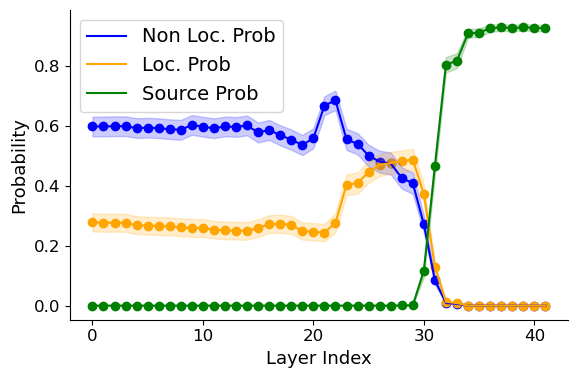

In [65]:
from tools.patchscope import plot_avg_probs_ax
fig, ax = plot_avg_probs_ax(outputs_df.query("country!='xUnited States'"), include_source=True)
fig.savefig("imp_patchscope_fixed_prompts.pdf", dpi=300, bbox_inches='tight')


In [ ]:
# translated hint
# english non-hint

(600, 42)


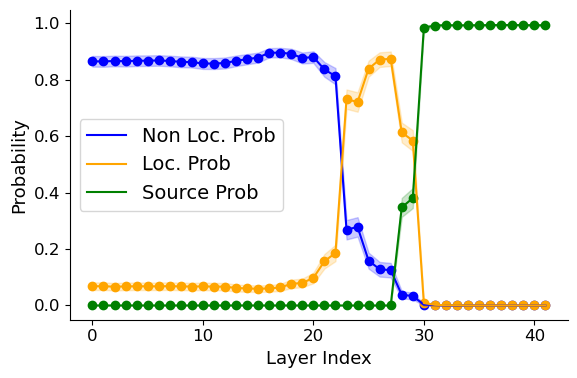

In [27]:
from tools.patchscope import plot_avg_probs_ax
plot_avg_probs_ax(outputs_df.query("country!='xRussia'"), include_source=True)

In [6]:

steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_pos.pt", weights_only=True)
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_neg.pt", weights_only=True)

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

FileNotFoundError: [Errno 2] No such file or directory: 'residuals/gemma2_9b_it/tr_pos.pt'

In [25]:
from tools.evaluation import get_answer_type_final

query = "country=='Turkey' and hint=='none' and lang!='English'"

samples = final_df.query(query).copy()

samples["ans_type"] = samples["ans_type_w_pref"]
samples["input_en"] = samples["question_id"].apply(lambda qid: final_df.query("question_id == @qid and lang == 'English'")["input"].values[0])
samples["input_en"] = samples["input_en"] + prompt_suffix["English"]

vector = steering_vec_map["tr"]

In [26]:
layers = [21,22,23,24,25,26,27]
rows = []
for idx, samp in samples.iterrows():
    source_prompt = samp["input"] + prompt_suffix[samp["lang"]]
    model_out = collect_residuals(nnmodel, source_prompt, calculate_probs=False)
    #model_out_en = collect_residuals(nnmodel, samp["input_en"], calculate_probs=False)
    residuals = model_out["residuals"][:,0,-1,:]# - model_out_en["residuals"][:,0,-1,:]
    for layer in layers:
        proj = t.inner(residuals[layer,:],vector[layer,0,:])
        proj = (proj/vector[layer,0,:].norm().item()).cpu().float().numpy()
        samp[f"layer_{layer}_proj"] = proj
    rows.append(samp)

projected_df = pd.DataFrame(rows)

In [23]:
# Explicit vector projection on translated prompts
projected_df.groupby("ans_type")[[f"layer_{layer}_proj" for layer in layers]].mean()

,layer_21_proj,layer_22_proj,layer_23_proj,layer_24_proj,layer_25_proj,layer_26_proj,layer_27_proj
ans_type,,,,,,,
local,-11.492989,-17.176403,-10.544841,-48.457953,-47.65527,-54.695468,-101.445183
none,4.307617,1.490234,4.619141,-25.71875,-11.600586,-5.929688,-45.1875
west,-8.694786,-13.542839,-9.705671,-45.867391,-45.361583,-52.467527,-97.830978


In [27]:
# Implicit vector projection on translated prompts
projected_df.groupby("ans_type")[[f"layer_{layer}_proj" for layer in layers]].mean()

,layer_21_proj,layer_22_proj,layer_23_proj,layer_24_proj,layer_25_proj,layer_26_proj,layer_27_proj
ans_type,,,,,,,
local,5.824968,-2.815858,13.031561,-32.440199,-19.422407,-30.553338,-90.283223
none,8.851562,-1.930664,14.984375,-27.5625,-2.699219,-2.9375,-58.625
west,7.344497,-0.854755,14.089912,-30.815217,-18.299881,-30.30377,-89.483696


## Evaluate Steering

### Calculate Steering Vecs

In [6]:
# Per culture

steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]


avg_type = "micro"

for prefix in ["tr", "fr", "ru", "bn"]:
    print(prefix)
    steering_vecs = []
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3_imp/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3_imp/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en)

        if avg_type == "macro":
            steering_vecs.append(steering_vec.mean(dim=0))
        else:
            steering_vecs.append(steering_vec)
    
    print(len(steering_vecs))
    steering_vec = t.cat(steering_vecs, dim=0)
    print(steering_vec.shape)
    steering_vec = steering_vec.mean(dim=0)

    steering_vec_map[("micro",prefix)] = steering_vec.unsqueeze(1)
    t.save(steering_vec,f"vectors/gemma2_9b_it/implicit/{prefix}_avg_all_tasks.pt")

#steering_vec = steering_vec_map["tr"]

tr
4
torch.Size([201, 42, 3584])
fr
4
torch.Size([169, 42, 3584])
ru
4
torch.Size([108, 42, 3584])
bn
4
torch.Size([220, 42, 3584])


In [7]:
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]

avg_type = "micro"

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    print(prefix)
    steering_vecs = []
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en)

        if avg_type == "macro":
            steering_vecs.append(steering_vec.mean(dim=0))
        else:
            steering_vecs.append(steering_vec)
    
    print(len(steering_vecs))
    steering_vec = t.cat(steering_vecs, dim=0)
    print(steering_vec.shape)
    steering_vec = steering_vec.mean(dim=0)
    steering_vec_map[("transmicro",prefix)] = steering_vec.unsqueeze(1)
    t.save(steering_vec,f"vectors/gemma2_9b_it/per_culture/{prefix}_trans_avg_all_tasks.pt")


tr
4
torch.Size([232, 42, 3584])
fr
4
torch.Size([165, 42, 3584])
ru
4
torch.Size([267, 42, 3584])
bn
4
torch.Size([117, 42, 3584])
us
4
torch.Size([206, 42, 3584])


In [ ]:
steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]
#tasks = ["names"]

avg_type = "micro"
for pref_to_skip in ["tr", "fr", "ru", "bn", "us"]:
    pref_to_skip = "us"
    for prefix in ["tr", "fr", "ru", "bn", "us"]:
        steering_vecs = []
        if prefix == pref_to_skip:
            continue
        for task in tasks:
            res_tr = t.load(f"residuals/gemma2_9b_it_v3/{prefix}_{task}_pos.pt", weights_only=True)
            res_en = t.load(f"residuals/gemma2_9b_it_v3/{prefix}_{task}_neg.pt", weights_only=True)

            steering_vec = (res_tr - res_en)

            if avg_type == "macro":
                steering_vecs.append(steering_vec.mean(dim=0))
            else:
                steering_vecs.append(steering_vec)
        
        print(len(steering_vecs))

    steering_vec = t.cat(steering_vecs, dim=0)
    print(steering_vec.shape)

    steering_vec = steering_vec.mean(dim=0)
    t.save(steering_vec,f"vectors/gemma2_9b_it/universal/en_universal_{pref_to_skip}_out.pt")

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    steering_vec_map[("micro",prefix)] = steering_vec.unsqueeze(1)

tr
4
fr
8
ru
12
bn
16
us
torch.Size([1403, 42, 3584])


In [23]:
#steering_vec_map = {}
steering_vecs = []
tasks = ["names", "cities", "culturedistil", "culturebench"]
#tasks = ["names"]

for prefix in ["tr", "fr", "ru", "bn", "us"]:
    print(prefix)
    for task in tasks:
        res_tr = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_pos.pt", weights_only=True)
        res_en = t.load(f"residuals/gemma2_9b_it_v3_trans/{prefix}_{task}_neg.pt", weights_only=True)

        steering_vec = (res_tr - res_en).mean(dim=0)

        print(steering_vec.shape)
        t.save(steering_vec,f"vectors/gemma2_9b_it/per_task/{prefix}_{task}_trans.pt")
        steering_vec_map[(task,prefix)] = steering_vec.unsqueeze(1)

tr
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
fr
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
ru
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
bn
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
us
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])
torch.Size([42, 3584])


### Open-ended

In [6]:
prompt = """
<bos><start_of_turn>user
Can you describe me a traditional dance?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [8]:
tokenizer.tokenize(prompt, add_special_tokens=False)

['<bos>',
 '<start_of_turn>',
 'user',
 '\n',
 'Can',
 '▁you',
 '▁describe',
 '▁me',
 '▁a',
 '▁traditional',
 '▁dance',
 '?',
 '\n',
 '<end_of_turn>',
 '\n',
 '<start_of_turn>',
 'model',
 '\n']

In [103]:
prompt = """
<bos><start_of_turn>user
Can you give me a traditional recipe?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [111]:
open_ended_examples = pd.read_json(f"data/open_ended_generation/{pref}_False.json")


NameError: name 'pref' is not defined

In [92]:
print(tr_inputs[0])

<bos><start_of_turn>user
Bana yerel bir yemeğin tarifini yaz.<end_of_turn>
<start_of_turn>model



In [67]:
from tools.prepare_input import messages_to_str

pref = "tr"
open_ended_examples = pd.read_json(f"data/open_ended_generation/{pref}_False.json")

en_prompts = open_ended_examples["story"].tolist()
tr_prompts = open_ended_examples["translation"].tolist()


en_inputs = [messages_to_str([{"role": "user", "content": prompt}], tokenizer, instruction_model=True) for prompt in en_prompts]
tr_inputs = [messages_to_str([{"role": "user", "content": prompt}], tokenizer, instruction_model=True)  for prompt in tr_prompts]

In [66]:
dance_prompt = """
<bos><start_of_turn>user
Can you describe me a traditional dance?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

dish_prompt = """
<bos><start_of_turn>user
Write me a recipe for a local dish.<end_of_turn>
<start_of_turn>model
""".strip()+"\n"


In [ ]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import trange

alpha = 2

steering_vec = steering_vec_map[("enuniversal_loo","tr")]

out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=dish_prompt_tr, layer=[21,22,23,24,25], n_new_tokens=50, use_sampling=True)


In [68]:
dish_prompt_tr = tr_inputs[0]

In [142]:
out[0]

{21: ['Please tell me what region or country you consider "local"!  \n\nI need to know where you are to give you a recipe for a local dish. For example, are you looking for a recipe from:\n\n* **A specific country?**'],
 22: ["##  Moussaka (Greek)\n\nMoussaka is a classic Greek dish that's hearty, flavorful, and perfect for a family meal. \n\n**Ingredients:**\n\n* **For the eggplant:**\n    * 2 large egg"],
 23: ['##  Spicy Shrimp & Chorizo Paella (Spanish)\n\nThis paella is a vibrant, flavorful dish featuring local Spanish ingredients. \n\n**Yields:** 4 servings\n**Prep Time:** 20 minutes\n**Cook Time:** '],
 24: ['##  Maafe, a West African Peanut Stew \n\nThis recipe is for a traditional West African dish called Maafe, a flavorful and hearty stew made with peanut butter, meat, and vegetables. \n\n**Ingredients:**\n\n* **Meat:**'],
 25: ["##  Cassoulet Toulousain (Toulouse Cassoulet)\n\nThis is a classic dish from the city of Toulouse, in the south of France. It's a hearty and flavorf

In [72]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import trange

alpha=0

outs_dict = {}
for pref in ["tr"]:#, "fr", "ru", "bn", "us"]:
    steering_vec = steering_vec_map[("enuniversal_loo",pref)]
    outs = []
    for i in trange(5):
        out = contrastive_act_gen_opt(nnmodel, 
                                      tokenizer, 
                                      alpha * steering_vec, 
                                      prompt=dish_prompt_tr, layer=[25], 
                                      n_new_tokens=20, use_sampling=True)
        outs.extend(out[0][25])
    outs_dict[pref] = outs


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


In [71]:
outs_dict

{'tr': ["## Ankara'nın Lezzeti:  **Çubuk Tatlısı**\n\n**Mal",
  "##  İstanbul'un Lezzeti: İskender Kebap\n\n**İstanbul'",
  "##  Türk Mutfağının Lezzeti: İzmir'in Meşhur **Ku",
  "## Karadeniz'in Lezzeti: Hamsi Pilavı\n\n**Malzemeler:**",
  '##  İçli Köfte (İçli Koftes)\n\n**İçli']}

In [73]:
outs_dict

{'tr': ['Üzgünüm, ama yerel bir yemek tarifi veremem. Ben bir dil modeliyim ve',
  'Üzgünüm ama ben bir dil modeliyim, gerçek dünyada yemek pişiremem veya tarif',
  'Ben bir dil modeli olarak, fiziksel olarak yemek pişiremem veya tat alma duyumuna sahip',
  'Ben bir dil modeliyim, gerçek dünyada yemek pişiremiyorum veya yerel yemekleri deneyim',
  "##  Tavuk Şiş (Türk Yemeği)\n\nBu tarif, Türkiye'nin hemen"]}

In [149]:
outs_dict

{'tr': ["##  Antalya'nın Lezzeti: **Testi Kebabı**\n\n**Malzeme",
  "##  İzmir'in Lezzeti:  **İzmir Tava**\n\n**Mal",
  'Üzgünüm, ama yerel bir yemek tarifi veremem. Çünkü ben bir dil modeliyim',
  '## Trabzon Hamsi Böreği\n\n**Malzemeler:**\n\n* **Hamur',
  "## Trabzon Karadeniz Hamsi Tava\n\nTrabzon'un meşhur"]}

In [134]:
outs_dict

{'tr': ['##  Spicy Sichuan Mapo Tofu (麻婆豆腐)\n\nThis recipe is for a classic Sichuan dish, showcasing the bold flavors of Sichuan peppercorns and chili peppers. \n\n**Ingredients:**\n\n* **For the Tofu:**\n    * '],
 'fr': ['##  Moussaka (Greek)\n\n**Moussaka** is a classic Greek dish featuring layers of eggplant, ground meat, and creamy béchamel sauce. \n\n**Ingredients:**\n\n* **For the eggplant:**\n    * '],
 'ru': ['##  Spicy Sichuan Mapo Tofu (麻婆豆腐)\n\n**This recipe is for a traditional Sichuan dish featuring silken tofu in a spicy, savory sauce.**\n\n**Ingredients:**\n\n* **For the Tofu:**\n    * 1 block ('],
 'bn': ['##  Spicy Shrimp and Coconut Curry (Thai Green Curry)\n\nThis recipe features a vibrant Thai green curry, a staple in Thailand, bursting with flavor and spice.\n\n**Ingredients:**\n\n* **For the Curry Paste:**\n    * 1'],
 'us': ['Please tell me what region or country you\'d like a recipe for!  \n\nFor example, you could say:\n\n* "Write me a recipe for a local dish 

In [122]:
outs_dict

{'tr': ['Üzgünüm, ama ben bir dil modeliyim ve fiziksel dünyayla etkileşim kuramam. Bu yüzden bir yemeğin tarifini veremem.\n\nYerel bir yemek tarifini bulmak için çevrimiçi olarak araştırab',
  "##  Karadeniz'in Lezzeti: Mıhlama\n\nMıhlama, Karadeniz bölgesinin en sevilen ve geleneksel yemeklerinden biridir. Bu enfes lezzetin ana malzemesi",
  'Üzgünüm, ama yerel bir yemek tarifini veremem. Çünkü bir yapay zekâ olarak, fiziksel dünyada bulunmadığım için "yerel" kavramını anlayamıyorum. \n\nHangi bölgede ya',
  'Ben bir dil modeliyim, bu yüzden yemek pişiremem veya yerel yemekler hakkında bilgiye erişemem. \n\nYerel bir yemeğin tarifini bulmak için sana yardımcı olabilirim! \n\nHangi bölgede yaşı',
  'Ben bir dil modeliyim, fiziksel olarak yemek pişiremiyorum veya yerel tariflere erişimim yok. Yerel bir yemek tarifini bulmak için çevrimiçi olarak arama yapabilir veya yerel bir yemek kitabına bakabilirsiniz.',
  'Elbette! \n\n**Trabzon Hamsi Tava**\n\nBu tarif, Karadeniz bölgesine özgü,

In [115]:
outs_dict

{'fr': ["##  Gratin Dauphinois revisité : \n\n**Un plat savoyard revisité avec une touche d'originalité.**\n\n**Ingrédients (pour 4 personnes) :**\n\n* 1 kg de pommes de terre à chair",
  '## Bouillabaisse Provençale \n\n**Ingrédients pour 4 personnes:**\n\n* **Poisson:**\n    * 500g de poisson blanc (colin, rascasse, rouget, etc.) en morceaux\n    * ',
  '## La Choucroute Garnie alsacienne\n\n**Ingrédients pour 4 personnes :**\n\n* 500g de choucroute fermentée\n* 250g de lardons fumés\n* 2 sauc',
  '## Cassoulet provençal \n\n**Ingrédients (pour 6 personnes) :**\n\n* 300g de haricots secs (blanc ou gris)\n* 500g de saucisse de Toulouse\n*',
  '## La Choucroute Garnie Alsacienne\n\n**Ingrédients pour 4 personnes:**\n\n* 500g de choucroute fermentée\n* 2 saucisses de Strasbourg\n* 2 saucisses de campagne\n',
  "##  Poulet au citron et olives, un classique de la Provence\n\n**Ingrédients (pour 4 personnes) :**\n\n* 1 poulet fermier découpé en morceaux\n* 2 cuillères à soupe d'huile d'oli

In [113]:
outs_dict

{'fr': ['##  Cassoulet Toulousain \n\n**Un plat emblématique de la région Occitanie, le cassoulet toulousain est une véritable fête pour les papilles !**\n\n**Ingrédients (pour 6 personnes) :**\n\n',
  '##  Cassoulet Toulousain\n\n**Un plat emblématique de la région Occitanie, le Cassoulet Toulousain est un ragoût de haricots blancs, de viande et de saucisses, mijoté lentement dans',
  '##  Tarte fine aux oignons et lardons du terroir (Lorraine)\n\n**Ingrédients:**\n\n* **Pâte:**\n    * 250g de farine\n    * 125g de lardons fumés\n    ',
  '##  Cassoulet Toulousain \n\n**Un plat traditionnel de la région Occitanie, le cassoulet toulousain est un ragoût de haricots blancs, de viande et de saucisse, mijoté lentement dans',
  '##  La Galette Bretonne : Un classique breton revisité\n\n**Ingrédients:**\n\n* **Pour la pâte :**\n    * 250g de farine de blé noir\n    * 125g de farine blanche',
  '##  La Choucroute Garnie alsacienne\n\n**Un plat traditionnel alsacien, savoureux et réconfortant 

In [102]:
outs_dict

{'tr': ["##  İzmir'in Lezzeti: **Künefe**\n\nİzmir'in en meşhur tatlılarından biri olan Künefe, şerbetli, yumuşacık ve çok lezzetli bir tatlıdır.",
  "##  İzmir'in Lezzeti:  **Künefe**\n\nİzmir'in meşhur tatlısı Künefe, şerbetli, peynirli ve çıtır çıtır bir lezzet şöleni",
  "##  İzmir'in Lezzeti: **İzmir Tava**\n\n**Malzemeler:**\n\n* 1 kg dana kıyma\n* 5 adet orta boy soğan, ince kıyılmış\n* 2 adet",
  "##  Karadeniz'in Lezzeti: **Mıhlama**\n\n**Malzemeler:**\n\n* 2 su bardağı Pirinç\n* 1 su bardağı Kaşar peyniri\n*",
  'Yerel bir yemek tarifini vermek için, hangi bölgenin yemeklerini istediğinizi bilmem gerekiyor! \n\nLütfen bana hangi ülkenin, bölgenin veya şehrin yemeklerini tercih ettiğinizi söyleyin. Örne',
  "## Trabzon Hamsi Buğlama\n\nTrabzon'un meşhur lezzeti olan Hamsi Buğlama, balık severlerin mutlaka deneyimlemesi gereken bir yemek. \n\n**Malzemeler:**\n\n*",
  'Üzgünüm, ama yerel bir yemek tarifini yazmam mümkün değil. Çünkü ben bir dil modeliyim, yerel bir yemek tarifin

In [ ]:
'##  Hünkar Beğendi (Turkish Royal Dish)\n\nThis is a classic Turkish dish, named after "Hünkar" (Sultan) and "Beğendi" (loved), reflecting its royal status and deliciousness. It features'
"##  **Muhammara - Syrian Red Pepper and Walnut Dip**\n\n**Muhammara** is a delicious and vibrant dip from Syria, made with roasted red peppers, walnuts, pomegranate molasses, and spices. It's traditionally served with **"

"##  Cassoulet Toulousain (Toulouse Cassoulet)\n\nThis is a classic dish from Toulouse, France, known for its rich flavors and hearty ingredients. \n\n**Ingredients:**\n\n* **For the Cassoulet:**\n"
"##  Moules Marinières (Mussels in White Wine Sauce) - A Belgian Classic\n\n**Ingredients:**\n\n* 2 lbs fresh mussels, scrubbed and debearded\n* 1/2 cup dry white wine\n* 1/"

"##  Borscht (Ukrainian Beetroot Soup)\n\n**This recipe is for a traditional Ukrainian borscht, a hearty and flavorful beetroot soup that is a staple in Ukrainian cuisine.**\n\n**Ingredients:**\n\n* **For the borscht:**\n"
"##  **Khachapuri Adjaruli (Georgian Cheese Bread) **\n\n**This is a traditional Georgian dish, a must-try in the heart of the country. **\n\n**Ingredients:**\n\n* **For the Dough:**\n    '

"##  **Chana Masala (Bengali Chickpea Curry)**\n\nThis is a flavorful and aromatic chickpea curry, a staple in Bengali cuisine. It's traditionally made with Bengal gram (chana), potatoes, and a blend of spices."

"##  New England Clam Chowder (Classic)\n\nThis recipe is a classic New England staple, packed with clams, potatoes, and bacon. It's a hearty and comforting dish perfect for a chilly day.\n\n**Ingredients:**\n\n* "

In [25]:
pd.to_pickle(outs_dict, "open_ended/micro25_2_dish_out.pkl")

In [31]:
dance_out = pd.read_pickle("open_ended/micro25_2_dance_out.pkl")

In [37]:
import json

with open("open_ended/avg_en_dish_out.json", "w") as f:
    json.dump(outs_dict, f)

In [158]:
out

({22: ['Please tell me what region or country you\'d like a local dish from! \n\nFor example, you could say:\n\n* "A recipe for a local dish from Tuscany"\n* "A recipe for a local dish from Vietnam"\n* "A recipe for a local dish from the Philippines"\n\n\nI can give you a traditional recipe or one with a modern twist.  Let me know! \n<end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos>\n<eos><end_of_turn><eos><eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<eos><end_of_turn><eos>\n<end_of_turn><eos>\n<eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn><eos>\n<end_of_turn>\n<eos>\n<end_of_turn><eos>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn><eos>\n<end_of_turn>\n<end_of_turn>

In [ ]:
# tr recipe, alpha=4.0, culturedistil vec, l 25
# fr recipe, alpha=5.0, culturedistil vec, l 25,26,27

In [109]:
out[0]

{22: ["##  Traditional French Onion Soup (Soupe à l'oignon gratinée)\n\nThis recipe is a classic example of French cuisine, known for"]}

### Steering Test Data

In [6]:
#test_data = pd.read_csv("model_gen/gemma2_9b_it_greedy_mult_choice.csv")
test_data = pd.read_csv("model_gen/swapped/gemma2_9b_it.csv")

test_data["options"] = test_data["options"].apply(eval_or_skip)
test_data.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data["subtask"] = test_data["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))

names_data = test_data.query("subtask=='names' and lang=='English'").copy()
cities_data = test_data.query("subtask=='cities' and lang=='English'").copy()
rest_data = test_data.query("subtask!='names' and subtask!='cities'").copy()


dfs = [rest_data]

question_ids = list(rest_data["question_id"].unique())

for country in ["Turkey", "France", "Russia", "Bangladesh"]:
    for df, samp_size in [(names_data,1), (cities_data,5)]:
        country_df = df.query(f"country=='{country}'")

        unique_ans_west = country_df["ans_west"].unique()
        unique_ans_local = country_df["ans_local"].unique()

        w_df = pd.concat([country_df[country_df["ans_west"] == ans].sample(n=samp_size, random_state=42) for ans in unique_ans_west])
        rm_ans = set(unique_ans_local) - set(w_df["ans_local"])
        l_df = pd.concat([country_df[country_df["ans_local"] == ans].sample(n=samp_size, random_state=42) for ans in rm_ans])
        question_ids.extend(pd.concat([w_df,l_df])["question_id"].unique())

question_ids = set(question_ids)


steering_test_data = test_data.query("question_id in @question_ids").copy()

In [62]:
steering_test_data.to_csv("data/steering_test_data.csv", index=False)

### Steering Eval

In [31]:
steering_vec_map = {}
for c_pref in ["tr", "fr", "ru", "bn", "us"]:
    steering_vec_map[("enmicro", c_pref)] = t.load(f"vectors/gemma2_9b_it/per_culture/{c_pref}_en_avg_all_tasks.pt")
    steering_vec_map[("transmicro", c_pref)] = t.load(f"vectors/gemma2_9b_it/per_culture/{c_pref}_trans_avg_all_tasks.pt")
    steering_vec_map[("enuniversal", c_pref)] = t.load(f"vectors/gemma2_9b_it/universal/en_universal_all_cultures.pt")
    steering_vec_map[("transuniversal", c_pref)] = t.load(f"vectors/gemma2_9b_it/universal/trans_universal_all_cultures.pt")
    steering_vec_map[("enuniversal_loo", c_pref)] = t.load(f"vectors/gemma2_9b_it/universal/en_universal_{c_pref}_out.pt").unsqueeze(1)
    steering_vec_map[("transuniversal_loo", c_pref)] = t.load(f"vectors/gemma2_9b_it/universal/trans_universal_{c_pref}_out.pt").unsqueeze(1)

    if c_pref != "us":
        steering_vec_map[("implicit", c_pref)] = t.load(f"vectors/gemma2_9b_it/implicit/{c_pref}_avg_all_tasks.pt").unsqueeze(1)

    for task in ["names", "cities", "culturedistil", "culturebench"]:
        steering_vec_map[("en"+task, c_pref)] = t.load(f"vectors/gemma2_9b_it/per_task/{c_pref}_{task}_en.pt")
        steering_vec_map[("trans"+task, c_pref)] = t.load(f"vectors/gemma2_9b_it/per_task/{c_pref}_{task}_trans.pt")

/tmp/ipykernel_1191/4114787718.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering_vec_map[("enmicro", c_pref)] = t.load(f"vectors/gemma2_9b_it/per_culture/{c_pref}

In [38]:
test_data = pd.read_csv("model_gen/all_models_eval_subset.csv")
test_data = test_data.query("model=='gemma2_9b_it'").copy()

test_data["options"] = test_data["options"].apply(eval_or_skip)
test_data.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data["subtask"] = test_data["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))
test_data = test_data.query("hint==False").copy()

test_data.shape

(5987, 19)

In [39]:
from tools.contrastiveact import contrastive_act_gen_opt
from tqdm import tqdm


#layers = [24, 25, 26, 27]
#layers = [15,16,17,18,19,20,21,22,23,24,25] + [26,27,28,29,30]
layers = [21,22,23,24,25,26,27]# + [15,16,17,18,19,20,28,29,30]
#layers = [15,16,17,18,19,20,28,29,30]
#layers = [15,16,17,18,19,20,28,29,30]
#layers = [21]


#alphas = [1,2,3]
alphas = [-2,-1]
#alphas = [2]

#alphas = [0]
outputs = []

batch_size = 64


for country in ["United States"]:
    for task in ["names", "cities", "culturedistil", "culturebench"]:
        print(country, task)
        s = country_to_suffix[country]
        if s == "us":
            pass
            #continue
        steering_vec = steering_vec_map[("transuniversal_loo",s)]
        test_entries = test_data.query("country==@country and subtask==@task").to_dict(orient="records")

        batch_entries = [test_entries[k:k+batch_size] for k in range(0, len(test_entries), batch_size)]
        batch_inputs = [[entry["input"] for entry in batch] for batch in batch_entries]

        for i,batch_imp in tqdm(enumerate(batch_inputs), total=len(batch_inputs)):
            for alpha in alphas:
                with t.no_grad():
                    out = contrastive_act_gen_opt(nnmodel, tokenizer, alpha * steering_vec, prompt=batch_imp, layer=layers, n_new_tokens=1)
                    for j,layer in enumerate(out[0]):
                        texts = out[0][layer]
                        probs = out[1]
                        epsilon = 1e-6
                        probs[probs < epsilon] = 0

                        for k, text in enumerate(texts):
                            out_dict = {"alpha": alpha, "steer_out": text, "steer_prob": probs[j,k,:,:].to_sparse(), "layer": layer}
                            out_dict.update(batch_entries[i][k])
                            outputs.append(out_dict)
                            pass

United States names


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:02<00:00,  8.91s/it]


United States cities


100%|██████████| 6/6 [00:58<00:00,  9.77s/it]


United States culturedistil


100%|██████████| 6/6 [01:45<00:00, 17.65s/it]


United States culturebench


100%|██████████| 1/1 [00:15<00:00, 15.41s/it]


In [40]:
pd.to_pickle(outputs, "caa/gemma2_9b_it_v3/subset_us_transunivloo_neglayer.pkl")
#pd.to_pickle(outputs, "caa/testdata_allcountry_nosteer.pkl")

In [ ]:
outputs = pd.read_pickle("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_upper.pkl")
#outputs = pd.read_pickle("caa/gemma2_9b_it_no_steer_batch_mult_4.pkl")

In [41]:
from tqdm import tqdm


same_token_questions = set()
new_rows = []

setting = "mult_choice"

for out in tqdm(outputs):

    if setting == "mult_choice":
        out["ans_west"] = str(int(out["ans_west_idx"]))
        out["ans_local"] = str(int(out["ans_local_idx"]))

    west_ind = tokenizer.encode(out["ans_west"], add_special_tokens=False)[0]
    out["prob_west"] = out["steer_prob"][0,west_ind].item()



    local_ind = tokenizer.encode(out["ans_local"], add_special_tokens=False)[0]
    out["prob_local"] = out["steer_prob"][0,local_ind].item()


    if out["ans_west"] in str(out["steer_out"]):
        out["ans_type"] = "west"
    elif out["ans_local"] in str(out["steer_out"]):
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"

    new_rows.append(out)

  0%|          | 0/16254 [00:00<?, ?it/s]

100%|██████████| 16254/16254 [00:02<00:00, 6777.34it/s]


In [42]:
steer_df = pd.DataFrame(new_rows)
steer_df.to_csv("caa/gemma2_9b_it_v3/subset_us_transunivloo_neglayer.csv", index=False)

In [43]:
per_steer_df = pd.concat(
    [pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_posalpha.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remainalpha.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_2627.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_alpha3.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remaininglayer.csv")  
    ])

per_steer_df["vector"] = "pertask"


name_steer_df = pd.concat([pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_upper.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv"),
                      pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_alpha3.csv")])

name_steer_df["vector"] = "names"

steer_df = pd.concat([per_steer_df, name_steer_df])


/tmp/ipykernel_1191/3087529440.py:6: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_pertask_remaininglayer.csv")
/tmp/ipykernel_1191/3087529440.py:12: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  name_steer_df = pd.concat([pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis.csv"),
/tmp/ipykernel_1191/3087529440.py:14: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_names_layeranalysis_highalpha.csv"),


In [44]:
en_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enuniversal_mainlayers.csv")
en_steer_df["vector"] = "enuniversal"

trans_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transuniversal_mainlayers.csv")
trans_steer_df["vector"] = "transuniversal"

steer_df = pd.concat([steer_df, en_steer_df, trans_steer_df])


/tmp/ipykernel_1191/396987571.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  en_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enuniversal_mainlayers.csv")
/tmp/ipykernel_1191/396987571.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_steer_df = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transuniversal_mainlayers.csv")


In [45]:
en_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enunivloo_mainlayers_alpha1.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enunivloo_mainlayers_alpha2.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_us_enunivloo_neglayer.csv"),
])
en_steer_df["vector"] = "enuniversal_loo"

trans_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transunivloo_mainlayers_alpha1.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transunivloo_mainlayers_alpha2.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_us_transunivloo_neglayer.csv"),
])

trans_steer_df["vector"] = "transuniversal_loo"

steer_df = pd.concat([steer_df, en_steer_df, trans_steer_df])

/tmp/ipykernel_1191/1286455336.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transunivloo_mainlayers_alpha1.csv"),
/tmp/ipykernel_1191/1286455336.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transunivloo_mainlayers_alpha2.csv"),


In [46]:
en_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_mainlayers.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_otherlayers.csv"),
])
en_steer_df["vector"] = "enmicro"

swap_steer = pd.read_csv("caa/gemma2_9b_it_v3/subset_swapped_allcountry_enmicro_mainlayers.csv")

swap_steer["vector"] = "enmicro_swap"

trans_steer_df = pd.concat([
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_mainlayers.csv"),
    pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_otherlayers.csv"),
])

trans_steer_df["vector"] = "transmicro"

imp_steer_df = pd.concat([pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_implicit_mainlayers.csv"),
                          pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_implicit_otherlayers.csv")])
imp_steer_df["vector"] = "implicit"

steer_df = pd.concat([steer_df, en_steer_df, trans_steer_df, swap_steer, imp_steer_df])

/tmp/ipykernel_1191/4100229966.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_mainlayers.csv"),
/tmp/ipykernel_1191/4100229966.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_enmicro_otherlayers.csv"),
/tmp/ipykernel_1191/4100229966.py:7: DtypeWarning: Columns (1,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  swap_steer = pd.read_csv("caa/gemma2_9b_it_v3/subset_swapped_allcountry_enmicro_mainlayers.csv")
/tmp/ipykernel_1191/4100229966.py:12: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_transmicro_mainlayers.csv"),
/tmp/ipykernel_1191/4100229966.py:13: DtypeWarning: Columns (18) have mixed types. Specify dtype optio

In [47]:
steer_df.shape

(2712224, 28)

In [48]:
def get_abs_type(out):
    if str(int(out["ans_west_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "west"
    elif str(int(out["ans_local_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"
    return out["ans_type"]

steer_df["ans_type"] = steer_df.apply(get_abs_type, axis=1)

In [49]:

steer_df["unique_id"] = steer_df["question_id"].astype(str) + steer_df["lang"] + steer_df["country"] + steer_df["hint"].astype(str)
unique_ids = set(steer_df["unique_id"].unique())

no_steer_res = pd.read_csv("caa/gemma2_9b_it_v3/subset_allcountry_no_steer.csv")
no_steer_res["unique_id"] = no_steer_res["question_id"].astype(str) + no_steer_res["lang"] + no_steer_res["country"] + no_steer_res["hint"].astype(str)

no_steer_res = no_steer_res.query("unique_id in @unique_ids").copy()

dfs = []
for l in steer_df["layer"].unique():
    n = no_steer_res.copy()
    n["vector"] = "none"
    n["layer"]=l
    dfs.append(n)
no_steer_res = pd.concat(dfs)


steer_df = [steer_df, no_steer_res]
steer_df = pd.concat(steer_df)

steer_df.drop(columns=["steer_prob"], inplace=True)

In [50]:
steer_df.query("vector=='enuniversal_loo'")["alpha"].unique()

array([ 1,  2, -2, -1])

In [51]:
steer_df["key"] = steer_df["question_id"] + steer_df["country"]

In [52]:
keys = set(steer_df["key"].unique())
hinted = pd.read_csv("model_gen/all_models_eval_subset.csv").query("model =='gemma2_9b_it' and hint==True").copy()
hinted["key"] = hinted["question_id"] + hinted["country"] 
hinted = hinted.query("key in @keys").copy()

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

hinted["subtask"] = hinted["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))

hinted["local_ans"] = (hinted["ans_type"] == "local").astype(int)
hinted["west_ans"] = (hinted["ans_type"] == "west").astype(int)
hinted["no_ans"] = (hinted["ans_type"] == "none").astype(int)



In [53]:
steer_df["local_ans"] = (steer_df["ans_type"] == "local").astype(int)
steer_df["west_ans"] = (steer_df["ans_type"] == "west").astype(int)
steer_df["no_ans"] = (steer_df["ans_type"] == "none").astype(int)

steer_df = steer_df.merge(
    steer_df.query("alpha == 0")[["question_id", "country", "lang", "hint", "subtask", "layer", "local_ans", "west_ans", "no_ans"]].rename(columns={"local_ans": "local_ans_base", "west_ans": "west_ans_base", "no_ans": "no_ans_base"}),
    on=["question_id","lang", "subtask", "layer", "hint", "country"],
    how="inner"
)
steer_df["delta_local_ans"] = steer_df["local_ans"] - steer_df["local_ans_base"]
steer_df["delta_west_ans"] = steer_df["west_ans"] - steer_df["west_ans_base"]
steer_df["delta_no_ans"] = steer_df["no_ans"] - steer_df["no_ans_base"]

In [54]:
steer_df["translated"] = steer_df.apply(lambda x: x["lang"] != "English" or x["country"]=='United States', axis=1)
hinted["translated"] = hinted.apply(lambda x: x["lang"] != "English" or x["country"]=='United States', axis=1)

In [55]:
## per culture vectors
vectors_to_look = ["enmicro", "transmicro", "names", "enuniversal_loo", "transuniversal_loo", "transuniversal", "enuniversal"]

vector_renaming = {"enmicro": "per-culture (en)", 
                   "transmicro": "per-culture (translated)", 
                   "names": "names (en)",
                   "enuniversal_loo": "held-out universal (en)",
                   "transuniversal_loo": "held-out universal (translated)",
                   "transuniversal": "universal (translated)",
                   "enuniversal": "universal (en)"}



disp_df = steer_df.query("vector in @vectors_to_look and alpha<3").merge(hinted[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "country", "translated"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","country","translated"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer

,vector,alpha,layer,country,translated,local_ans_steer,local_ans_no_steer,local_ans_hinted
486,per-culture (en),2,21,Bangladesh,False,0.769896,0.543253,0.955017
487,per-culture (en),2,21,Bangladesh,True,0.738754,0.628028,0.894464
380,per-culture (en),1,25,France,False,0.693103,0.524138,0.898276
489,per-culture (en),2,21,France,True,0.612069,0.546552,0.884483
526,per-culture (en),2,25,Russia,False,0.872072,0.497297,0.926126
...,...,...,...,...,...,...,...,...
2570,held-out universal (translated),2,27,Russia,False,0.556757,0.497297,0.926126
2553,held-out universal (translated),2,25,Russia,True,0.690090,0.531532,0.877477
2572,held-out universal (translated),2,27,Turkey,False,0.634286,0.548571,0.944286
2573,held-out universal (translated),2,27,Turkey,True,0.680000,0.558571,0.918571


In [56]:
best_alpha_layer.to_csv("best_steering_res_per_culture_fixed.csv", index=False)

In [38]:
# per-task 
vectors_to_look = ["pertask","names","enmicro"]


vector_renaming = {"pertask": "per-task-culture (en)",
                   "enmicro": "per-culture (en)", 
                   "transmicro": "per-culture (translated)", 
                   "names": "names (en)",
                   "enuniversal_loo": "held-out universal (en)",
                   "transuniversal_loo": "held-out universal (translated)",
                   "transuniversal": "universal (translated)",
                   "enuniversal": "universal (en)"}



disp_df = steer_df.query("vector in @vectors_to_look and lang=='English' and alpha<3").merge(hinted[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "subtask"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","subtask"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer


,vector,alpha,layer,subtask,local_ans_steer,local_ans_no_steer,local_ans_hinted
232,per-culture (en),2,25,cities,0.872816,0.466019,1.000000
225,per-culture (en),2,23,culturebench,0.793011,0.741935,0.881720
234,per-culture (en),2,25,culturedistil,0.614173,0.484252,0.844488
227,per-culture (en),2,23,names,0.733564,0.551903,0.914360
500,names (en),2,21,cities,0.896117,0.466019,1.000000
501,names (en),2,21,culturebench,0.798387,0.741935,0.881720
502,names (en),2,21,culturedistil,0.624016,0.484252,0.844488
503,names (en),2,21,names,0.770761,0.551903,0.914360
736,per-task-culture (en),1,25,cities,0.806796,0.466019,1.000000
785,per-task-culture (en),2,21,culturebench,0.776882,0.741935,0.881720


In [39]:
best_alpha_layer.to_csv("best_steering_res_per_task_on_eng.csv", index=False)

In [14]:
en_implicit_results = steer_df.query("vector=='implicit' and lang=='English'").copy()
en_implicit_results["country"] = "United States"
en_implicit_results["translated"] = True
en_implicit_results["alpha"] = - en_implicit_results["alpha"]
en_implicit_results[["ans_local", "ans_west", "ans_local_idx", "ans_west_idx"]] = en_implicit_results[["ans_west","ans_local", "ans_west_idx", "ans_local_idx"]]
en_implicit_results[["local_ans", "west_ans", "local_ans_base", "west_ans_base"]] = en_implicit_results[["west_ans","local_ans", "west_ans_base", "local_ans_base"]]
en_implicit_results["delta_local_ans"] = en_implicit_results["local_ans"] - en_implicit_results["local_ans_base"]
en_implicit_results["delta_west_ans"] = en_implicit_results["west_ans"] - en_implicit_results["west_ans_base"]

In [ ]:

vector_renaming = {"enmicro": "per-culture (en)", 
                   "transmicro": "per-culture (translated)", 
                   "names": "names (en)",
                   "enuniversal_loo": "held-out universal (en)",
                   "transuniversal_loo": "held-out universal (translated)",
                   "transuniversal": "universal (translated)",
                   "enuniversal": "universal (en)",
                   "implicit": "implicit"}

us_question_ids = set(steer_df.query("country=='United States'")["question_id"].unique())

disp_df = pd.concat([steer_df.query("vector=='implicit' and lang!='English' and alpha<3"), en_implicit_results.query("question_id in @us_question_ids")]).merge(hinted[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "country", "translated"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","country","translated"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer.drop(columns=["local_ans_hinted"], inplace=True)
best_alpha_layer

,vector,alpha,layer,country,translated,local_ans_steer,local_ans_no_steer
210,implicit,1,25,Bangladesh,True,0.695502,0.628028
296,implicit,2,26,France,True,0.594828,0.546552
212,implicit,1,25,Russia,True,0.614414,0.531532
283,implicit,2,23,Turkey,True,0.654286,0.558571
214,implicit,1,25,United States,True,0.621392,0.517827


In [50]:
best_alpha_layer.to_csv("best_steering_res_implicit_per_culture.csv", index=False)

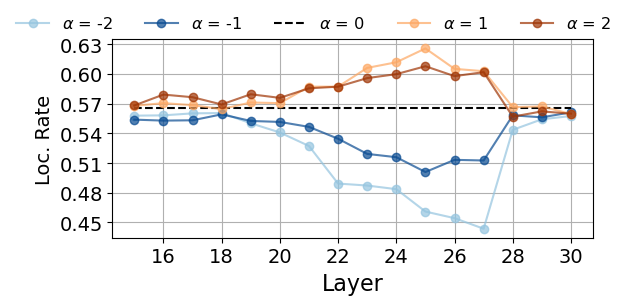

In [15]:
import numpy as np
import matplotlib.pyplot as plt

title_map = {
    "cities": "Cities",
    "names": "Names", 
    "culturedistil": "CultureDistil",
    "culturebench": "CulturalBench"
}
us_question_ids = set(steer_df.query("country=='United States' and vector=='enmicro'")["question_id"].unique())
query = "lang!='xEnglish' and alpha<3 and alpha>-3"
disp_df = pd.concat([steer_df.query("(vector=='implicit' or vector=='none') and lang!='English' and alpha<3"), en_implicit_results.query("question_id in @us_question_ids")]).merge(hinted[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
disp_df["title"] = disp_df["lang"].apply(lambda x: "" if x == "English" else "")

#disp_df = steer_df.query(query + " and (vector=='enmicro' or vector=='none')").copy()
#disp_df["title"] = disp_df["lang"].apply(lambda x: "English" if x == "English" else "Non-English")

disp_df["layer"] = disp_df["layer"].astype(int)

# If you still need hinted_subs:
# hinted_subs = hinted.query(query)

########################################################################
# 1) Identify unique alpha values and split into negative vs positive
########################################################################
all_alphas = sorted(disp_df["alpha"].unique())  # ascending order
negative_alphas = [a for a in all_alphas if a < 0]
positive_alphas = [a for a in all_alphas if a > 0]

########################################################################
# 2) Create color mappings
#    - For negative alphas: use Blues (from lighter to darker or vice versa).
#    - For positive alphas: use Oranges (from lighter to darker or vice versa).
########################################################################
# You can adjust np.linspace(...) ranges or pick another colormap if you prefer.
neg_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_alphas)))
pos_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(positive_alphas)))

alpha_color_map = {}
for alpha_val, color_val in zip(negative_alphas, neg_colors):
    alpha_color_map[alpha_val] = color_val
for alpha_val, color_val in zip(positive_alphas, pos_colors):
    alpha_color_map[alpha_val] = color_val

########################################################################
# 3) Create subplots, one per "title" group
########################################################################
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'axes.labelsize': 13
})

subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 3), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure we have an iterable of axes

########################################################################
# 4) Iterate over each subplot (by "title") and plot mean ± 95% CI
#    for each alpha, in ascending order of alpha.
########################################################################
for ax, (src, group) in zip(axes, disp_df.groupby("title")):
    # If you only want top layers, you can filter here; otherwise skip
    # group = group[group["layer"].isin(top_layers[src])] 
    
    # Sort alpha in ascending order so the legend goes from negative -> positive
    for alpha_val in sorted(group["alpha"].unique()):
        # Skip alpha=0 if you do not want it (or handle it separately)
        if alpha_val == 0:
            pass
        
        alpha_grp = group[group["alpha"] == alpha_val]
        
        # For each layer, we gather all local_ans values
        layer_groups = alpha_grp.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers
        layers = sorted(layer_groups.index)
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            # 95% CI ~ mean ± 1.96*SEM
            ci = 1.96 * sem
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        

        # Plot line (mean) and fill for CI
        if alpha_val == 0:
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                linestyle="dashed",
                color="black"
            )
        else:
            # Get color for current alpha
            color = alpha_color_map[alpha_val]
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                color=color,
                marker='o',
                alpha=0.7
            )
        
    #ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.plot()
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

axes[-1].set_xlabel("Layer")

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='small', frameon=False)
# Reduce whitespace and lower the font size of the legend
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small')
# Make legend small
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='small')
# Make font of tick params larger
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Ensure x-ticks are integers
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels))
plt.tight_layout(pad=1.0)
# Save the figure
fig.savefig("steering_eng_noneng_large.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [11]:
steer_df["vector"].unique()

array(['enuniversal', 'transuniversal', 'enmicro', 'transmicro',
       'enmicro_swap', 'none'], dtype=object)

In [12]:
layers_to_include = [21,22,23,24,25,26,27]

enmicro_steer = steer_df.query("vector == 'enmicro' and layer in @layers_to_include")
enmicro_swap_steer = steer_df.query("vector == 'enmicro_swap' and layer in @layers_to_include")

merged=enmicro_steer.merge(enmicro_swap_steer, on=["question_id", "lang", "country", "alpha", "layer"], suffixes=("_enmicro", "_enmicro_swap"), how="inner")

In [ ]:
# line plot showing all la

In [13]:
merged.query("alpha==1 and layer==21").shape

(5987, 69)

In [41]:
merged["alpha"].unique()

array([-2, -1,  1,  2])

In [31]:
subs = merged.copy().query("alpha == 1 and layer==25 and lang=='English'")# and layer==25")

In [32]:
len(subs)

3574

In [35]:
(subs["ans_type_enmicro"] == subs["ans_type_enmicro_swap"]).sum() / len(subs)

0.6776720761052043

In [34]:
(subs["steer_out_enmicro"] != subs["steer_out_enmicro_swap"]).sum() / len(subs)

0.6866256295467263

In [ ]:
steer_df.query("vector=='enmicro_swap' and question_id=='synth_names_0_tr' and alpha==1 and layer==25")

,alpha,steer_out,layer,source_id,question_id,country,question,lang,options,hint,...,unique_id,local_ans,west_ans,no_ans,local_ans_base,west_ans_base,no_ans_base,delta_local_ans,delta_west_ans,delta_no_ans
935124,1,2,25,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"['Alparslan', 'Liam']",False,...,synth_names_0_trEnglishTurkeyFalse,0,1,0,1,0,0,-1,1,0
935125,1,2,25,synth_names,synth_names_0_tr,Turkey,Aşağıdaki isimlerden hangisi muhtemelen benim ...,Turkish,"['Alparslan', 'Liam']",False,...,synth_names_0_trTurkishTurkeyFalse,0,1,0,1,0,0,-1,1,0


In [33]:
steer_df.query("vector=='enmicro' and question_id=='synth_names_0_tr' and alpha==1 and layer==25")

,alpha,steer_out,layer,source_id,question_id,country,question,lang,options,hint,...,unique_id,local_ans,west_ans,no_ans,local_ans_base,west_ans_base,no_ans_base,delta_local_ans,delta_west_ans,delta_no_ans
168788,1,2,25,synth_names,synth_names_0_tr,Turkey,Which of the following names is most likely to...,English,"['Liam', 'Alparslan']",False,...,synth_names_0_trEnglishTurkeyFalse,1,0,0,1,0,0,0,0,0
168789,1,2,25,synth_names,synth_names_0_tr,Turkey,Aşağıdaki isimlerden hangisi muhtemelen benim ...,Turkish,"['Liam', 'Alparslan']",False,...,synth_names_0_trTurkishTurkeyFalse,1,0,0,1,0,0,0,0,0


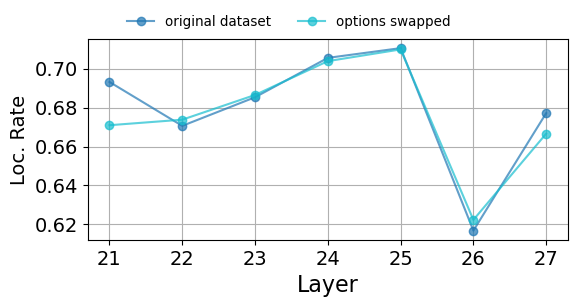

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

title_map = {
    "cities": "Cities",
    "names": "Names", 
    "culturedistil": "CultureDistil",
    "culturebench": "CulturalBench"
}

########################################################
# 0) Create disp_df without restricting vectors
########################################################
# (Remove the `(vector=='enuniversal' or vector=='none')` part)
query = "lang!='xEnglish' and alpha<3 and alpha>-3 and layer<28 and layer>20"
disp_df = steer_df.query(query).copy()

# Optional: If you still want a column marking 'English' vs 'Non-English'
disp_df["title"] = disp_df["lang"].apply(
    lambda x: "" if x == "English" else ""
)

########################################################
# 1) Filter down to alpha=0 only
########################################################
disp_df_alpha0 = disp_df[disp_df["alpha"] == 2].copy()

########################################################
# 2) Create subplots by "title" group (if you want them)
#    If you only want a single plot, skip grouping by "title".
########################################################
subtasks = disp_df_alpha0["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 3), sharex=True, sharey=False)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure an iterable of axes if there's only one subplot

# Define a color mapping for each vector type (5 total)
vector_types = ["enmicro", "enmicro_swap"]#, "transmicro", "enuniversal_loo", "transuniversal_loo"]
#vector_types = ["none", "enmicro", "transmicro", "enuniversal_loo", "transuniversal_loo", "implicit"]
colors = plt.cm.tab10(np.linspace(0, 1, len(vector_types)))
vector_color_map = dict(zip(vector_types, colors))

# Update vec_title for more compact labels

vec_title = {
    "enmicro": "original dataset",
    "enmicro_swap": "options swapped",
    "implicit": "Implicit",
    "transmicro": "Tr-culture",
    "enuniversal_loo": "En-univ",
    "transuniversal_loo": "Tr-univ",
}

vec_title_x = {"enmicro": "En - per culture",
             "transmicro": "Tr. - per culture",
             "enmicro_swap": "En - per culture (swapped)",
            "transmicro_swap": "Tr. - per culture (swapped)",
             "enuniversal": "En - universal",
             "transuniversal": "Tr. - universal",}
# Set up some style preferences
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

########################################################
# 3) Iterate over each subplot (by "title") and plot 
#    mean ± 95% CI for each vector type.
########################################################
for ax, (title_value, group) in zip(axes, disp_df_alpha0.groupby("title")):
    hint_q = "lang=='English'" if title_value == "English" else "lang!='English'"
    hinted_subs = hinted.query(hint_q)
    # group is already filtered to alpha=0 and the current 'title'
    # Now group further by vector
    for vec in vector_types:
        vec_df = group[group["vector"] == vec]
        if vec_df.empty:
            continue
        
        # Group by layer to get list of local_ans values
        layer_groups = vec_df.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers numerically
        layers = sorted(layer_groups.index)
        
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error of the mean
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            ci = 1.96 * sem  # 95% CI ~ ±1.96 * SEM
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        # Plot line and fill for CI
        color = vector_color_map[vec]
        ax.plot(
            layers, means,
            label=vec_title[vec], 
            color=color,
            marker='o',
            alpha=0.7,
        )
        #ax.fill_between(layers, ci_low, ci_high, color=color, alpha=0.2)
    # Plot dashed line for alpha=0 per layer in disp_df
    '''
    alpha0_group = disp_df[(disp_df["alpha"] == 0) & (disp_df["title"]==title_value)].groupby("layer")["local_ans"].mean()
    ax.plot(
        alpha0_group.index, alpha0_group.values,
        label="w/o steer",
        linestyle="dashed",
        color="black"
    )
    '''
    ax.plot()
    ax.set_title(title_value)
    ax.set_ylabel("Loc. Rate")  # or "Loc. Rate"
    #ax.axhline(hinted_subs["local_ans"].mean(), color='red', linestyle='--', label="w/ Context")
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    ax.grid(True)
    # Add a single legend for the entire figure
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
#fig.legend(handles, labels, loc='right', bbox_to_anchor=(1, 1))
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[-1].set_xlabel("Layer")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize='x-small', frameon=False)
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small', frameon=False)

#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small', frameon=False)
# Reduce whitespace and lower the font size of the legend
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='x-small')
# Make legend small
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='small')
# Make font of tick params larger
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top
#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels))
plt.tight_layout(pad=1.1)
# Save the figure

plt.tight_layout()
plt.show()
fig.savefig("universal_vs_culturespecific.pdf", dpi=300, bbox_inches='tight')

In [49]:
best_alpha = 5
best_layer = 22

query = "lang=='English'"

# Filter the dataframe for the best alpha
best_alpha_df = steer_df.query("alpha == @best_alpha and layer == @best_layer")

# Group by subtask and calculate the mean localization rate
performance_by_subtask = best_alpha_df.query(query).groupby('subtask')['local_ans'].mean().reset_index()
hinted_rate = hinted.query(query).groupby("subtask")["local_ans"].mean().reset_index()
performance_by_subtask = performance_by_subtask.merge(hinted_rate, on="subtask", suffixes=("_steer", "_hint"))

print(performance_by_subtask)

         subtask  local_ans_steer  local_ans_hint
0         cities         0.821809        1.000000
1   culturebench         0.275000        0.576923
2  culturedistil         0.520000        0.825666
3          names         0.751572        0.911980
